In [10]:
import numpy as np
from data import *
from network import *
import matplotlib.pyplot as plt

In [11]:
import tqdm
import pandas as pd

In [36]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [377]:
train_datas = load_data(train = True) #load train data

In [458]:
train_datas = load_data(train = True) #load train data

# retrieve binary data for labels 0 and 5
X=[]
Y=[]
for i in range(len(train_datas[0])):
    if i%10000 ==0:
        print(i) 
    #0 vs 5
    if train_datas[1][i] == 3 or train_datas[1][i] == 5:
        X.append(train_datas[0][i])
        Y.append(train_datas[1][i])
    

X=np.array(X)
Y=np.array(Y)
train_datas = (X,Y)

#changing labels from 0 to 1
for i in range(len(Y)):
    if Y[i]==3:
        Y[i] =1
    else:
        Y[i] =0

#normalized features
for i in range(len(X)):
    #X[i] = z_score_normalize(X[i])[0]
    X[i] = min_max_normalize(X[i])[0]

#shuffle datas
train_datas = shuffle(train_datas)

#train_datastrain = True

0
10000
20000
30000
40000


In [33]:
for i in range(10):
    print(np.sum(Y==1))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


In [ ]:
#plot

#3, 5

#soft max

In [19]:
table=pd.DataFrame()

In [20]:
try_lr=[0.001, 0.01]
try_batchsize=[1,5,10,20,64]
zeros=np.zeros(len(try_lr)*len(try_batchsize)).reshape(len(try_lr),len(try_batchsize))
df=pd.DataFrame(zeros, index=try_lr, columns=try_batchsize)
df[1][0.001]

0.0

### Hyper Parameter Tuning For 0 vs 5

In [459]:


try_lr=[ 0.0008 ]
try_batchsize=[5]

#initialize table to store values
zeros=np.zeros(len(try_lr)*len(try_batchsize)).reshape(len(try_lr),len(try_batchsize))
val_acc_df=pd.DataFrame(zeros, index=try_lr, columns=try_batchsize)

for lr in try_lr:
    for batchsize in try_batchsize:
        mvp_val_acc=0
        print(f'lr is {lr} and batch_size is {batchsize}')
    # --------------- K FOLD START ------------------------
        #k fold:
        folds = generate_k_fold_set(train_datas)
        epochs = 100

        #DATA to store / FOLDS
        val_loss = {}# record validation loss for each model trained in each fold (fold#: list of val loss per epoch)
        val_accuracy={}# record accuracy for each model trained in each fold
        train_loss={}#record train loss for each model trained in each fold
        train_accuracy={}# record validation loss for each model trained in each fold
        model = {}# store model trained in each fold

        count =0
        for i in folds:
            count+=1
            print(f"-----------------------------------------Begin Trainning for Fold {count}/10-----------------------------------------")
            val_set = i[1] # get validation set
            train_set = i[0] #get train set

            #Data To Store EPOCHs: record over each epoch
            epoch_train_loss=[]
            epoch_train_acc=[]
            epoch_val_loss=[]
            epoch_val_acc=[]

            #Initialize Model
            regressor = Network({'lr':lr},activation=sigmoid,loss_func = binary_cross_entropy,out_dim=1)

            #FOR EARLY stop: record best
            best_weight = regressor.weights #to store best weight
            best_val_loss = np.inf # to store lowest loss
            best_val_acc=0 # to store final acc

            #-------------------EPOCH START----------------------       
            for epoch in range(epochs):
                #print(f'epoch: {epoch+1}/{epochs}')
                # generate batches
                batches = generate_minibatches(train_set,batch_size=batchsize)
                batch_loss=[]
                #-------------------BATCH START----------------------
                for batch in batches:
                    X=batch[0]
                    y=batch[1]
                    #train the model, record loss for each batch
                    curr_batch_loss = regressor.train((X,y))
                    batch_loss.append(curr_batch_loss)
                #-------------------BATCH END----------------------
                #record average training loss of each batch for single epoch
                #curr_epoch_train_loss = np.mean(batch_loss) 
                curr_weights = regressor.weights


                train_set_loss_acc=regressor.test(train_set)
                curr_epoch_train_loss = train_set_loss_acc[0]
                curr_epoch_train_acc = train_set_loss_acc[1]

                #performance on validation dataset (fold):
                val_set_loss_acc=regressor.test(val_set)
                curr_epoch_val_loss = val_set_loss_acc[0]
                curr_epoch_val_acc = val_set_loss_acc[1]

                # -- EARLY STOP CHECK-- use validation set result to decide early stop
                if (curr_epoch_val_loss-best_val_loss)<0.01: # test if loss no longer decrease 
                    # if loss keep decrease
                    best_val_loss = curr_epoch_val_loss #update lowest loss value reached
                    best_val_acc=curr_epoch_val_acc
                    best_weight=curr_weights #store current weights
                else:
                    # if loss no longer decrease
                    regressor.weights=best_weight #reverse network weight to weight that produce lowest loss
                    print(f'early stop at {epoch}, current val loss{curr_epoch_val_loss}, last val loss{best_val_loss}')
                    print(f'early stop, current val accuracy{curr_epoch_val_acc}, last val accuracy{best_val_acc}')
                    break



                #Update Recorded Data: record over each epoch
                epoch_train_loss.append(curr_epoch_train_loss)
                epoch_train_acc.append(curr_epoch_train_acc)
                epoch_val_loss.append(curr_epoch_val_loss)
                epoch_val_acc.append(curr_epoch_val_acc)
        #-------------------EPOCH END---------------------- 
            

            # Update Recorded Values
            val_loss[f'fold {count}'] = epoch_val_loss
            val_accuracy[f'fold {count}'] = epoch_val_acc
            train_loss[f'fold {count}'] = epoch_train_loss
            train_accuracy[f'fold {count}'] = epoch_train_acc
            model[f'fold {count}']=regressor
    # --------------- 1 K FOLD END ------------------------
            
            if best_val_acc>mvp_val_acc:
                mvp_val_acc=best_val_acc
                mvp_weight = best_weight
            
        val_acc_df[batchsize][lr] = val_accuracy
        


lr is 0.0008 and batch_size is 5
-----------------------------------------Begin Trainning for Fold 1/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 2/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 3/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 4/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 5/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 6/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 7/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 8/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 9/10-

In [460]:
for i,j in val_accuracy.items():
    print(max(j))

0.579
0.592
0.582
0.607
0.604
0.588
0.599
0.599
0.584
0.591


In [346]:
model1

{'fold 1': <network.Network at 0x126422ef0>,
 'fold 2': <network.Network at 0x126422e90>,
 'fold 3': <network.Network at 0x126335ff0>,
 'fold 4': <network.Network at 0x126335ed0>,
 'fold 5': <network.Network at 0x126336020>,
 'fold 6': <network.Network at 0x11761acb0>,
 'fold 7': <network.Network at 0x11761b0d0>,
 'fold 8': <network.Network at 0x11761bca0>,
 'fold 9': <network.Network at 0x11761b700>,
 'fold 10': <network.Network at 0x11761a110>}

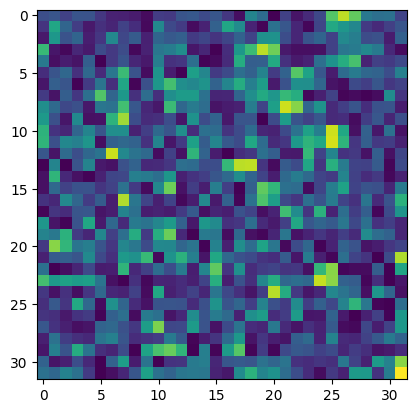

In [381]:
weights_sum=model['fold 1'].weights
for i in range(1,10):
    weights_sum=weights_sum+model[f'fold {i}'].weights

plt.imshow(np.abs(weights_sum[:-1]/10).reshape(32,32))
#plt.imshow(model['fold 9'].weights[:-1].reshape(32,32))


In [132]:
model['fold 5'].weights[:-1]

array([[-0.16506189],
       [-0.10959204],
       [-0.0317634 ],
       ...,
       [ 0.040412  ],
       [ 0.04808143],
       [ 0.08092017]])

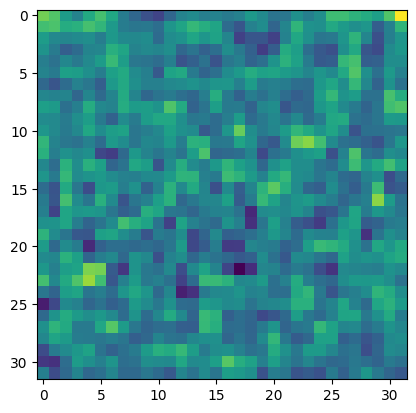

In [415]:
plt.imshow(((model1['fold 8'].weights[:-1])*255).reshape(32,32))

In [202]:
X = train_datas[0]
y=train_datas[1]

In [251]:
train_datas[0][train_datas[1]==0].mean(axis=0)

array([161.4878    , 160.45906667, 161.08153333, ..., 134.38506667,
       134.0838    , 134.52073333])

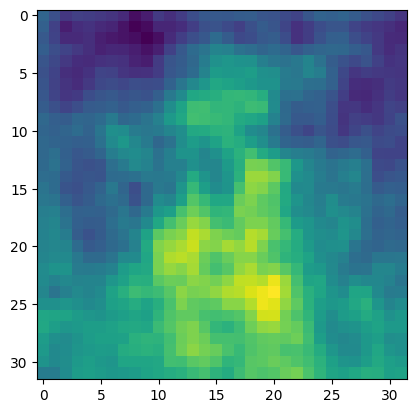

In [379]:
plt.imshow(train_datas[0][train_datas[1]==5][:100].mean(axis=0).reshape(32,32))

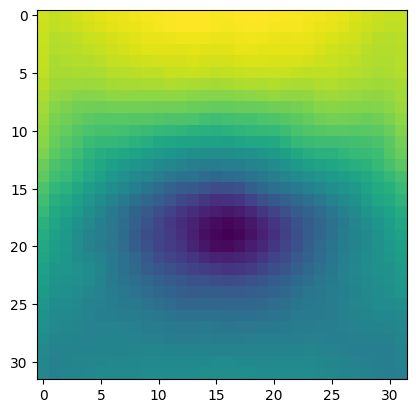

In [226]:
plt.imshow(train_datas[0][train_datas[1]==0].mean(axis=0).reshape(32,32))

In [129]:
np.array([0,0.001])*np.array([10,10])
X[y==0].mean(axis=0).shape
model['fold 5'].weights[:-1].reshape(1024,1).shape

(1024, 1)

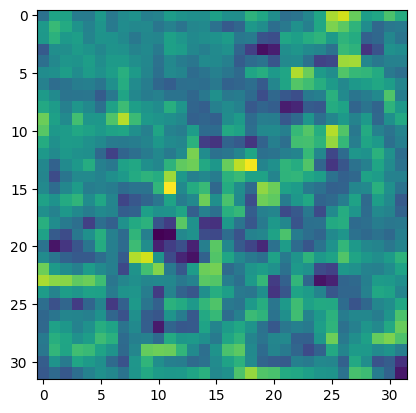

In [363]:
a=model['fold 1']
plt.imshow(((X[y].mean(axis=0))*(model['fold 7'].weights[:-1].reshape(1024))).reshape(32,32))


In [37]:
train_datas[0]

array([[0.2137931 , 0.19655172, 0.14137931, ..., 0.67586207, 0.60862069,
        0.55172414],
       [1.        , 0.98723404, 0.98723404, ..., 1.        , 1.        ,
        1.        ],
       [0.50983607, 0.50491803, 0.50983607, ..., 0.13442623, 0.13934426,
        0.13442623],
       ...,
       [0.31288344, 0.3190184 , 0.30368098, ..., 0.5797546 , 0.5797546 ,
        0.5506135 ],
       [0.90789474, 0.70657895, 0.8       , ..., 0.99473684, 0.99210526,
        1.        ],
       [0.8857645 , 0.88224956, 0.88224956, ..., 0.98066784, 0.98066784,
        0.97891037]])

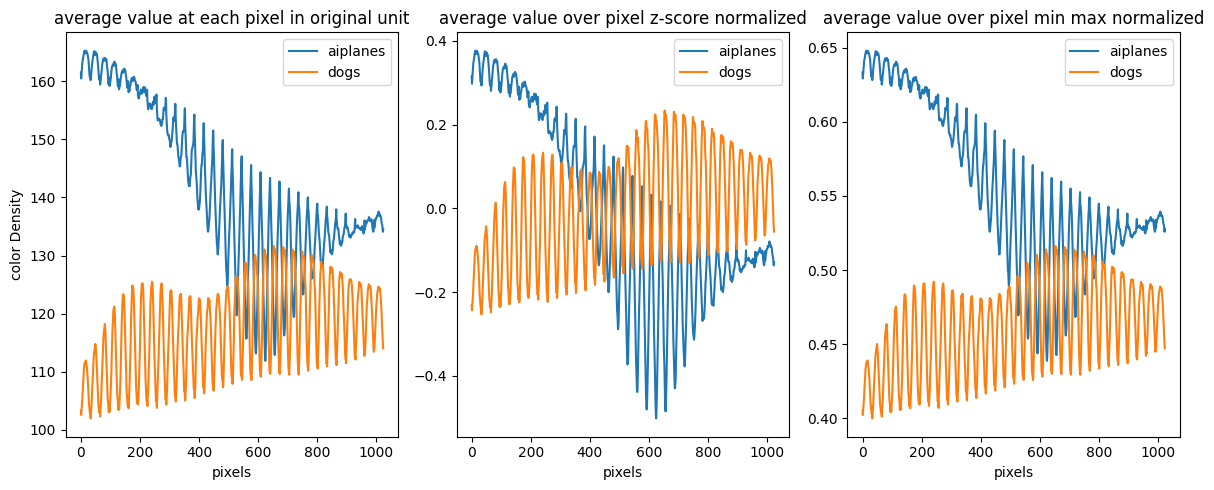

In [455]:
#Avergae Color Density at Each pixel
fig,axes=plt.subplots(1,3,figsize=(12,5))
#Original Unit
ax=axes[0]
ax.plot(airplanes.mean(axis=0), label='aiplanes')
ax.plot(dogs.mean(axis=0),label='dogs')
ax.set_title('average value at each pixel in original unit')
ax.legend()
ax.set_xlabel('pixels')
ax.set_ylabel('color Density')
#
ax=axes[1]
ax.plot(z_score_normalize(airplanes)[0].mean(axis=0), label='aiplanes')
ax.plot(z_score_normalize(dogs)[0].mean(axis=0),label='dogs')
ax.set_title('average value over pixel z-score normalized')
ax.set_xlabel('pixels')
ax.legend()
ax=axes[2]
ax.plot(min_max_normalize(airplanes)[0].mean(axis=0), label='aiplanes')
ax.plot(min_max_normalize(dogs)[0].mean(axis=0),label='dogs')
ax.set_title('average value over pixel min max normalized')
ax.set_xlabel('pixels')
ax.legend()

fig.tight_layout()

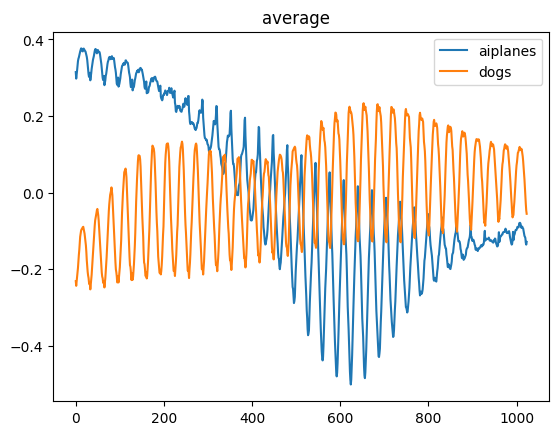

In [439]:
fig,ax=plt.subplots()
#ax.plot(((model1['fold 8'].weights[:-1])*255))
#ax.fill_between(np.arange(1024),airplanes.max(axis=0), airplanes.min(axis=0),alpha=0.1)
ax.plot(z_score_normalize(airplanes)[0].mean(axis=0), label='aiplanes')
#ax.fill_between(np.arange(1024),dogs.max(axis=0), dogs.min(axis=0),alpha=0.1)
ax.plot(z_score_normalize(dogs)[0].mean(axis=0),label='dogs')
ax.set_title('average  ')
ax.legend()

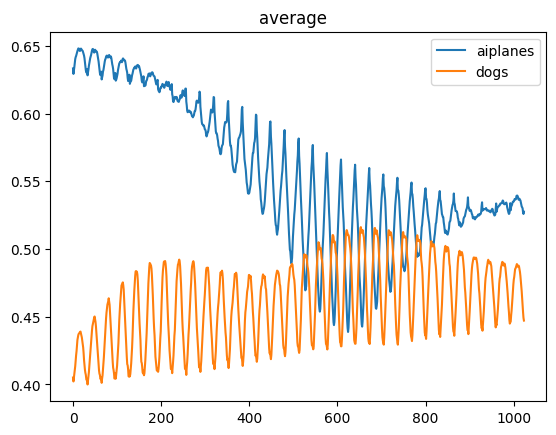

In [441]:
fig,ax=plt.subplots()
ax.plot(min_max_normalize(airplanes)[0].mean(axis=0), label='aiplanes')
ax.plot(min_max_normalize(dogs)[0].mean(axis=0),label='dogs')
ax.set_title('average  ')
ax.legend()

In [23]:
!python3 -m main --batch_size 3 --epochs 100 --learning_rate 0.0008 --z_score min --binary 1

fold #1...
	 we run 55 epochs

we trained 7.470436096191406 seconds for fold #1
fold #2...
	 we run 42 epochs

we trained 6.214500904083252 seconds for fold #2
fold #3...
	 we run 100 epochs

we trained 14.240448951721191 seconds for fold #3
fold #4...
	 we run 82 epochs

we trained 12.411419868469238 seconds for fold #4
fold #5...
	 we run 82 epochs

we trained 25.29410409927368 seconds for fold #5
fold #6...
	 we run 63 epochs

we trained 19.692577838897705 seconds for fold #6
fold #7...
	 we run 69 epochs

we trained 21.64535880088806 seconds for fold #7
fold #8...
	 we run 80 epochs

we trained 24.587544918060303 seconds for fold #8
fold #9...
	 we run 72 epochs

we trained 26.70697808265686 seconds for fold #9
fold #10...
	 we run 82 epochs

we trained 26.82076597213745 seconds for fold #10
best validation accs =  [0.701, 0.715, 0.746, 0.733, 0.734, 0.716, 0.735, 0.733, 0.726, 0.748]
avg validation accs =  0.7287000000000001
Best model test loss =  0.5537533819132259
Best model te

In [101]:
def summarize_data(x):
    #x is dictionary 
    result=[]
    for (i, j) in x.items():
        result.append(max(j))
    return result

In [102]:
val_acc_df.to_csv('modeltuning/logistic_tune2.csv')
avg_val_acc.to_csv('modeltuning/logistic_tune2_avg.csv')

In [103]:
avg_val_acc=val_acc_df.applymap(summarize_data).applymap(lambda x: np.mean(x))
# --> Lower Batchsize has higher Validation acc
avg_val_acc.mean(axis=1),avg_val_acc.mean(axis=0)

(0.00050    0.71772
 0.00010    0.70850
 0.00005    0.70536
 0.00001    0.69834
 dtype: float64,
 5     0.712350
 10    0.709650
 15    0.706750
 20    0.705275
 25    0.703375
 dtype: float64)

In [41]:
# !!!! No Early Stop Version!!!!!

try_lr=[0.001, 0.01]
try_batchsize=[32,64]

lr=0.001
batchsize=10

print(f'lr is {lr} and batch_size is {batchsize}')

#k fold:
folds = generate_k_fold_set(train_datas)
epochs = 100

#DATA to store / FOLDS
val_loss = {}# record validation loss for each model trained in each fold (fold#: list of val loss per epoch)
val_accuracy={}# record accuracy for each model trained in each fold
train_loss={}#record train loss for each model trained in each fold
train_accuracy={}# record validation loss for each model trained in each fold
model = {}# store model trained in each fold

count =0
for i in folds:
    count+=1
    print(f"-----------------------------------------Begin Trainning for Fold {count}/10-----------------------------------------")
    val_set = i[1] # get validation set
    train_set = i[0] #get train set

    #Data To Store EPOCHs: record over each epoch
    epoch_train_loss=[]
    epoch_train_acc=[]
    epoch_val_loss=[]
    epoch_val_acc=[]

    #Initialize Model
    regressor = Network({'lr':lr},activation=sigmoid,loss_func = binary_cross_entropy,out_dim=1)

    #FOR EARLY stop: record best
    best_weight = regressor.weights #to store best weight
    best_val_loss = np.inf # to store lowest loss
    best_val_acc=0 # to store final acc
   
    #-------------------EPOCH START----------------------       
    for epoch in range(epochs):
        #print(f'epoch: {epoch+1}/{epochs}')
        # generate batches
        batches = generate_minibatches(train_set,batch_size=batchsize)
        batch_loss=[]
        #-------------------BATCH START----------------------
        for batch in batches:
            X=batch[0]
            y=batch[1]
            #train the model, record loss for each batch
            curr_batch_loss = regressor.train((X,y))
            batch_loss.append(curr_batch_loss)
        #-------------------BATCH END----------------------
        #record average training loss of each batch for single epoch
        #curr_epoch_train_loss = np.mean(batch_loss) 
        curr_weights = regressor.weights
        
        
        train_set_loss_acc=regressor.test(train_set)
        curr_epoch_train_loss = train_set_loss_acc[0]
        curr_epoch_train_acc = train_set_loss_acc[1]

        #performance on validation dataset (fold):
        val_set_loss_acc=regressor.test(val_set)
        curr_epoch_val_loss = val_set_loss_acc[0]
        curr_epoch_val_acc = val_set_loss_acc[1]
        
        # -- EARLY STOP -- use validation set result to decide early stop
        if (curr_epoch_val_loss-best_val_loss)<0.001: # test if loss no longer decrease 
            # if loss keep decrease
            best_val_loss = curr_epoch_val_loss #update lowest loss value reached
            best_val_acc=curr_epoch_val_acc
            best_weight=curr_weights #store current weights
        else:
            # if loss no longer decrease
            regressor.weights=best_weight #reverse network weight to weight that produce lowest loss
            print(f'early stop at {epoch}, current val loss{curr_epoch_val_loss}, last val loss{best_val_loss}')
            print(f'early stop, current val accuracy{curr_epoch_val_acc}, last val accuracy{best_val_acc}')
            break
       


        #Update Recorded Data: record over each epoch
        epoch_train_loss.append(curr_epoch_train_loss)
        epoch_train_acc.append(curr_epoch_train_acc)
        epoch_val_loss.append(curr_epoch_val_loss)
        epoch_val_acc.append(curr_epoch_val_acc)
    #-------------------EPOCH END----------------------    
    
    # Update Recorded Values
    val_loss[f'fold {count}'] = epoch_val_loss
    val_accuracy[f'fold {count}'] = epoch_val_acc
    train_loss[f'fold {count}'] = epoch_train_loss
    train_accuracy[f'fold {count}'] = epoch_train_acc
    model[f'fold {count}']=regressor


lr is 0.001 and batch_size is 10
-----------------------------------------Begin Trainning for Fold 1/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 2/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 3/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 4/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 5/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 6/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 7/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 8/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 9/10-

In [75]:
final_accs=[acc[-1] for fold,acc in val_accuracy.items()]
np.mean(final_accs),final_accs

(0.722, [0.723, 0.734, 0.73, 0.757, 0.711, 0.704, 0.721, 0.719, 0.698, 0.723])

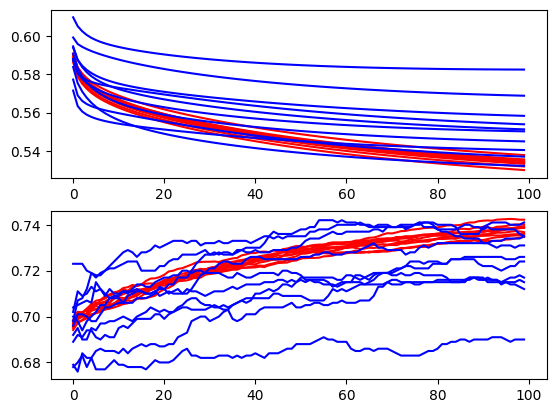

In [73]:
fig,ax = plt.subplots(2)
for (fold,loss) in train_loss.items():
    ax[0].plot(loss, label=fold, c='red')
for (fold,loss) in val_loss.items():
    ax[0].plot(loss, label=fold, c='blue')
    
for (fold,loss) in train_accuracy.items():
    ax[1].plot(loss, label=fold, c='red')
for (fold,loss) in val_accuracy.items():
    ax[1].plot(loss, label=fold, c='blue')

    #ax.legend()
    

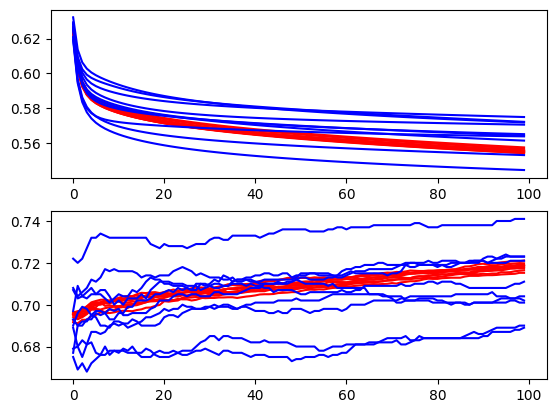

In [63]:
fig,ax = plt.subplots(2)
for (fold,loss) in train_loss.items():
    ax[0].plot(loss, label=fold, c='red')
for (fold,loss) in val_loss.items():
    ax[0].plot(loss, label=fold, c='blue')
    
for (fold,loss) in train_accuracy.items():
    ax[1].plot(loss, label=fold, c='red')
for (fold,loss) in val_accuracy.items():
    ax[1].plot(loss, label=fold, c='blue')

    #ax.legend()
    

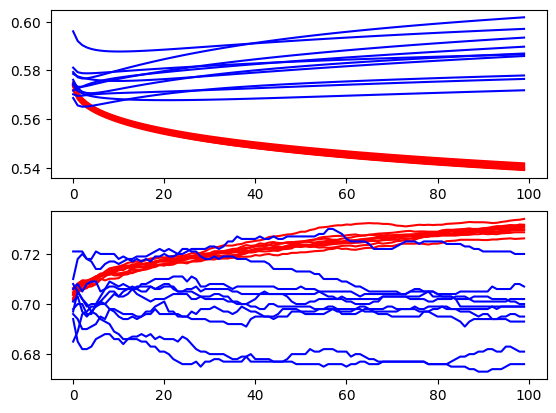

In [57]:
fig,ax = plt.subplots(2)
for (fold,loss) in train_loss.items():
    ax[0].plot(loss, label=fold, c='red')
for (fold,loss) in val_loss.items():
    ax[0].plot(loss, label=fold, c='blue')
    
for (fold,loss) in train_accuracy.items():
    ax[1].plot(loss, label=fold, c='red')
for (fold,loss) in val_accuracy.items():
    ax[1].plot(loss, label=fold, c='blue')

    #ax.legend()
    

In [60]:
np.log(0)

/var/folders/y9/kq138hps5jdgv8y5zls1m38h0000gn/T/ipykernel_33840/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [19]:


for lr in try_lr:
    for batch_size in try_batchsize :
        
        #k fold
        folds = generate_k_fold_set(train_datas)
        epochs = 100
        
        val_loss = []# record validation loss for each model trained in each fold
        val_accuracy=[]# record accuracy for each model trained in each fold
        train_loss=[]#record train loss for each model trained in each fold
        fold_epoch_train_loss={}#record all epoch losses stor in list for each fold
        fold_epoch_val_loss={}#record all epoch losses stor in list for each fold
        model = {}# store model trained in each fold
        count =0
        for i in folds:
            count+=1
            print(f"-----------------------------------------Begin Trainning for Fold {count}/10-----------------------------------------")
            val_set = i[1] # get validation set
            train_set = i[0] #get train set
            regressor = Network({'lr':lr},activation=sigmoid,loss_func = binary_cross_entropy,out_dim=1)
            epoch_train_loss=[]
            epoch_train_acc=[]
            epoch_val_loss=[]
            epoch_val_acc=[]

            best_weight = regressor.weights #to store best weight
            best_val_loss = np.inf # to store lowest loss
            best_val_acc=0 # to store final acc

            for epoch in range(epochs):
                #print(f'epoch: {epoch+1}/{epochs}')
                # generate batches
                batches = generate_minibatches(train_set)
                batch_loss=[]
                for batch in batches:
                    X=batch[0]
                    y=batch[1]
                    #train the model, record loss for each batch
                    batch_loss.append(regressor.train((X,y)))
                    #record average training loss of each batch for single epoch
                curr_epoch_train_loss = np.mean(batch_loss)
                #print(f"epoch loss:{np.mean(batch_loss)}")
                epoch_train_loss.append(curr_epoch_train_loss) 
                curr_weights = regressor.weights

                #performance on validation dataset (fold):
                val_set_loss_acc=regressor.test(val_set)
                curr_epoch_val_loss = val_set_loss_acc[0]
                epoch_val_loss.append(curr_epoch_val_loss) 
                curr_epoch_val_acc = val_set_loss_acc[1]
                epoch_val_acc.append(curr_epoch_val_acc) 
                # -- EARLY STOP -- use validation set result to decide early stop
                if (curr_epoch_val_loss-best_val_loss)<0.001: # test if loss no longer decrease 
                    # if loss keep decrease
                    best_val_loss = curr_epoch_val_loss #update lowest loss value reached
                    best_val_acc=curr_epoch_val_acc
                    best_weight=curr_weights #store current weights
                else:
                    # if loss no longer decrease
                    regressor.weights=best_weight #reverse network weight to weight that produce lowest loss
                    print(f'early stop at {epoch}, current val loss{curr_epoch_val_loss}, last val loss{best_val_loss}')
                    print(f'early stop, current val accuracy{curr_epoch_val_acc}, last val accuracy{best_val_acc}')
                    break

            fold_epoch_val_loss[count-1] =  best_val_acc

            # record all losses for each epoch in this fold
            fold_epoch_train_loss[f'fold {count}'] = epoch_train_loss
            # record model
            model[f'fold {count} model'] = regressor
            # test on validation set
            val_result = regressor.test(val_set)
            # record validation loss
            val_loss.append(val_result[0])
            #record validation accuracy
            val_accuracy.append(val_result[1])
            #record average train loss for this fold
            train_loss.append(np.mean(epoch_train_loss))
            
        print(np.mean(val_accuracy))




lr is 0.001 and batch_size is 32
-----------------------------------------Begin Trainning for Fold 1/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 2/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 3/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 4/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 5/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 6/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 7/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 8/10-----------------------------------------
-----------------------------------------Begin Trainning for Fold 9/10-

In [76]:
np.arange(10).reshape(10,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [79]:
np.arange(10).reshape(10,1)*np.arange(10,20).reshape(1,10)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
       [ 20,  22,  24,  26,  28,  30,  32,  34,  36,  38],
       [ 30,  33,  36,  39,  42,  45,  48,  51,  54,  57],
       [ 40,  44,  48,  52,  56,  60,  64,  68,  72,  76],
       [ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95],
       [ 60,  66,  72,  78,  84,  90,  96, 102, 108, 114],
       [ 70,  77,  84,  91,  98, 105, 112, 119, 126, 133],
       [ 80,  88,  96, 104, 112, 120, 128, 136, 144, 152],
       [ 90,  99, 108, 117, 126, 135, 144, 153, 162, 171]])

In [107]:
!python3 -m main --batch_size 3 --epochs 100 --learning_rate 0.0008 --z_score min --binary 1

fold #1...
	 we run 49 epochs

we trained 6.530692100524902 seconds for fold #1
fold #2...
	 we run 49 epochs

we trained 6.947127103805542 seconds for fold #2
fold #3...
	 we run 100 epochs

we trained 16.31501293182373 seconds for fold #3
fold #4...
	 we run 84 epochs

we trained 13.14755392074585 seconds for fold #4
fold #5...
	 we run 54 epochs

we trained 7.696217060089111 seconds for fold #5
fold #6...
	 we run 75 epochs

we trained 10.620741128921509 seconds for fold #6
fold #7...
	 we run 81 epochs

we trained 11.587285041809082 seconds for fold #7
fold #8...
	 we run 50 epochs

we trained 7.142384052276611 seconds for fold #8
fold #9...
	 we run 100 epochs

we trained 14.39778470993042 seconds for fold #9
fold #10...
	 we run 41 epochs

we trained 5.834234714508057 seconds for fold #10
best validation accs =  [0.732, 0.709, 0.74, 0.727, 0.724, 0.744, 0.733, 0.7, 0.738, 0.741]
avg validation accs =  0.7287999999999999
Best model test loss =  0.5560970009431787
Best model test a

In [112]:
!python3 -m main --batch_size 64 --epochs 100 --learning_rate 0.000001 --z_score "z_score" --binary 0

fold #1...
	 we run 61 epochs

we trained 55.90037417411804 seconds for fold #1
fold #2...
	 we run 58 epochs

we trained 58.324897050857544 seconds for fold #2
fold #3...
	 we run 59 epochs

we trained 52.52402091026306 seconds for fold #3
fold #4...
	 we run 61 epochs

we trained 51.81309962272644 seconds for fold #4
fold #5...
	 we run 59 epochs

we trained 77.19814705848694 seconds for fold #5
fold #6...
	 we run 61 epochs

we trained 54.180516958236694 seconds for fold #6
fold #7...
	 we run 63 epochs

we trained 53.95810890197754 seconds for fold #7
fold #8...
	 we run 61 epochs

we trained 54.94408988952637 seconds for fold #8
fold #9...
	 we run 62 epochs

we trained 55.05544972419739 seconds for fold #9
fold #10...
	 we run 59 epochs

we trained 51.20061111450195 seconds for fold #10
best validation accs =  [0.2198, 0.2082, 0.2014, 0.2072, 0.2008, 0.2156, 0.2192, 0.2078, 0.2158, 0.2012]
avg validation accs =  0.2097
Best model test loss =  11.425673178895835
Best model test ac

In [2]:
!python3 -m main --batch_size 32 --epochs 100 --learning_rate 0.00005 --z_score "z_score" --binary 0

fold #1...
	 we run 100 epochs

we trained 127.18721985816956 seconds for fold #1
fold #2...
	 we run 100 epochs

we trained 129.4400200843811 seconds for fold #2
fold #3...
	 we run 100 epochs

we trained 104.58904600143433 seconds for fold #3
fold #4...
	 we run 100 epochs

we trained 111.19127893447876 seconds for fold #4
fold #5...
	 we run 100 epochs

we trained 120.71205687522888 seconds for fold #5
fold #6...
	 we run 100 epochs

we trained 228.79612278938293 seconds for fold #6
fold #7...
	 we run 100 epochs

we trained 146.74346899986267 seconds for fold #7
fold #8...
	 we run 100 epochs

we trained 149.23599004745483 seconds for fold #8
fold #9...
	 we run 100 epochs

we trained 146.45493292808533 seconds for fold #9
fold #10...
	 we run 100 epochs

we trained 146.3137562274933 seconds for fold #10
best validation accs =  [0.2696, 0.2762, 0.2862, 0.2882, 0.2838, 0.297, 0.2868, 0.2794, 0.2844, 0.2772]
avg validation accs =  0.28287999999999996
Best model test loss =  2.0655164

In [3]:
!python3 -m main --batch_size 32 --epochs 100 --learning_rate 0.005 --z_score "z_score" --binary 0

fold #1...
	 we run 4 epochs

we trained 1.829509973526001 seconds for fold #1
fold #2...
	 we run 4 epochs

we trained 3.7821760177612305 seconds for fold #2
fold #3...
	 we run 4 epochs

we trained 4.412109851837158 seconds for fold #3
fold #4...
	 we run 4 epochs

we trained 4.131603956222534 seconds for fold #4
fold #5...
	 we run 3 epochs

we trained 3.2854909896850586 seconds for fold #5
fold #6...
	 we run 4 epochs

we trained 4.150943040847778 seconds for fold #6
fold #7...
	 we run 4 epochs

we trained 4.069259166717529 seconds for fold #7
fold #8...
	 we run 3 epochs

we trained 3.069852113723755 seconds for fold #8
fold #9...
	 we run 3 epochs

we trained 3.057845115661621 seconds for fold #9
fold #10...
	 we run 5 epochs

we trained 5.036440134048462 seconds for fold #10
best validation accs =  [0.2566, 0.2648, 0.2762, 0.2764, 0.2766, 0.2834, 0.2716, 0.2636, 0.2662, 0.2678]
avg validation accs =  0.27032
Best model test loss =  2.0867443168036983
Best model test accuracy = 

In [4]:
!python3 -m main --batch_size 32 --epochs 100 --learning_rate 0.0005 --z_score "z_score" --binary 0

fold #1...
	 we run 27 epochs

we trained 37.05629587173462 seconds for fold #1
fold #2...
	 we run 25 epochs

we trained 30.542091131210327 seconds for fold #2
fold #3...
	 we run 32 epochs

we trained 32.67481803894043 seconds for fold #3
fold #4...
	 we run 28 epochs

we trained 28.65101718902588 seconds for fold #4
fold #5...
	 we run 28 epochs

we trained 35.514596700668335 seconds for fold #5
fold #6...
	 we run 28 epochs

we trained 34.05017399787903 seconds for fold #6
fold #7...
	 we run 21 epochs

we trained 21.831202030181885 seconds for fold #7
fold #8...
	 we run 28 epochs

we trained 29.63146209716797 seconds for fold #8
fold #9...
	 we run 33 epochs

we trained 44.03587198257446 seconds for fold #9
fold #10...
	 we run 30 epochs

we trained 32.86768293380737 seconds for fold #10
best validation accs =  [0.2864, 0.29, 0.2856, 0.2732, 0.2778, 0.288, 0.2818, 0.2732, 0.2782, 0.28]
avg validation accs =  0.28142000000000006
Best model test loss =  2.0628465092885655
Best mode

In [5]:
!python3 -m main --batch_size 64 --epochs 100 --learning_rate 0.0001 --z_score "z_score" --binary 0

fold #1...
	 we run 100 epochs

we trained 94.11937999725342 seconds for fold #1
fold #2...
	 we run 100 epochs

we trained 108.55918312072754 seconds for fold #2
fold #3...
	 we run 100 epochs

we trained 117.95089817047119 seconds for fold #3
fold #4...
	 we run 100 epochs

we trained 138.68952083587646 seconds for fold #4
fold #5...
	 we run 100 epochs

we trained 124.55288910865784 seconds for fold #5
fold #6...
	 we run 100 epochs

we trained 94.30710816383362 seconds for fold #6
fold #7...
	 we run 100 epochs

we trained 98.75635004043579 seconds for fold #7
fold #8...
	 we run 100 epochs

we trained 97.12562108039856 seconds for fold #8
fold #9...
	 we run 100 epochs

we trained 103.04680824279785 seconds for fold #9
fold #10...
	 we run 100 epochs

we trained 93.08741593360901 seconds for fold #10
best validation accs =  [0.282, 0.289, 0.2772, 0.277, 0.2846, 0.2816, 0.277, 0.2706, 0.2884, 0.2884]
avg validation accs =  0.28158000000000005
Best model test loss =  2.0654388317720

In [9]:
a={'b':1}
a.b

AttributeError: 'dict' object has no attribute 'b'

In [7]:
!python3 -m main --batch_size 128 --epochs 100 --learning_rate 0.005 --z_score "z_score" --binary 0

fold #1...
	 we run 11 epochs

we trained 355.18096899986267 seconds for fold #1
fold #2...
	 we run 13 epochs

we trained 12.608350038528442 seconds for fold #2
fold #3...
	 we run 12 epochs

we trained 10.11019492149353 seconds for fold #3
fold #4...
	 we run 13 epochs

we trained 12.476902723312378 seconds for fold #4
fold #5...
	 we run 10 epochs

we trained 9.346975088119507 seconds for fold #5
fold #6...
	 we run 11 epochs

we trained 18.52240800857544 seconds for fold #6
fold #7...
	 we run 11 epochs

we trained 10.65575909614563 seconds for fold #7
fold #8...
	 we run 12 epochs

we trained 12.16034984588623 seconds for fold #8
fold #9...
	 we run 14 epochs

we trained 13.086019039154053 seconds for fold #9
fold #10...
	 we run 13 epochs

we trained 11.671342849731445 seconds for fold #10
best validation accs =  [0.2824, 0.2782, 0.2824, 0.2796, 0.2654, 0.279, 0.2726, 0.2788, 0.2748, 0.2794]
avg validation accs =  0.27725999999999995
Best model test loss =  2.066387398758335
Best

In [391]:
test_data = load_data(train = False) #load train data

In [394]:
pd.Series(test_data[1]).value_counts()

3    1000
8    1000
0    1000
6    1000
1    1000
9    1000
5    1000
7    1000
4    1000
2    1000
dtype: int64

In [400]:
train = load_data(train = True) #load train data

In [413]:
airplanes=train[0][train[1]==0]
dogs=train[0][train[1]==5]
cats=train[0][train[1]==3]

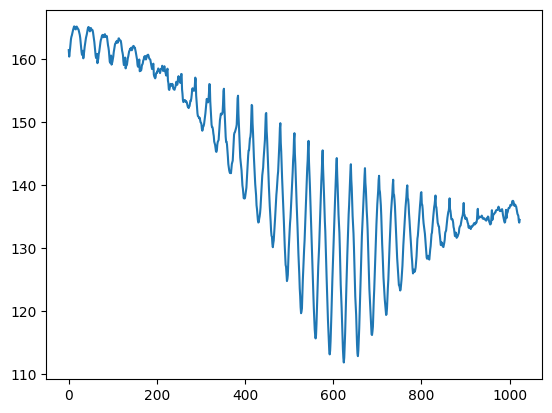

In [405]:
plt.plot(airplanes.mean(axis=0))

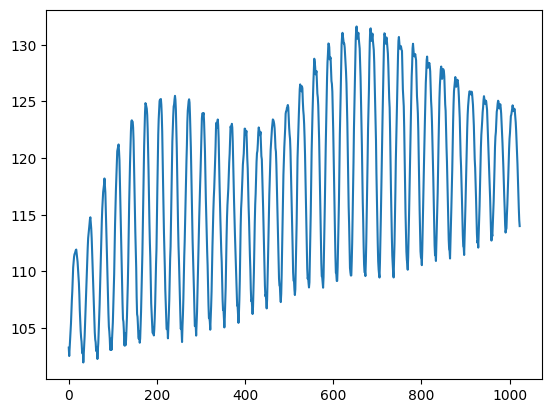

In [412]:
plt.plot(dogs.mean(axis=0))


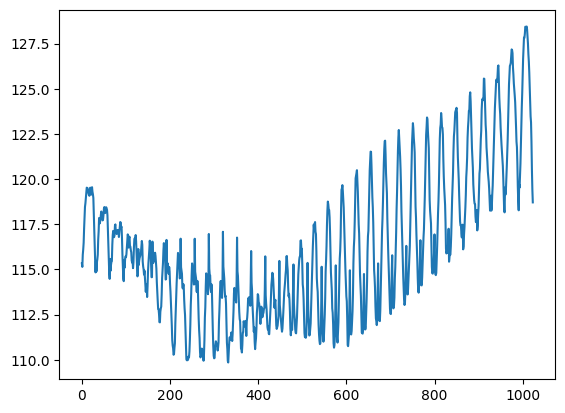

In [414]:
plt.plot(cats.mean(axis=0))

